In [14]:
library("tidyverse")
library("writexl")
library("readxl")
source("./code/plots.R")

# Figure 2

## code

In [3]:
disease <- read_tsv("./results/MRDN_nodes_category.txt")
fullname <- c("Bacterial Infections and Mycoses", 
              "Neoplasms", 
              "Cardiovascular Diseases", 
              "Digestive System Diseases", 
              "Hemic and Lymphatic Diseases", 
              "Immune System Diseases", 
              "Nutritional and Metabolic Diseases", 
              "Musculoskeletal Diseases", 
              "Nervous System Diseases", 
              "Parasitic Diseases", 
              "Respiratory Tract Diseases", 
              "Skin and Connective Tissue Diseases", 
              "Urogenital Diseases and Pregnancy Complications", 
              "Virus Diseases", 
              "Others"
             )
disease["Category"] <- factor(disease$Category, ordered=TRUE, levels=fullname)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Nodes = col_character(),
  Category = col_character()
)




In [12]:
f2a <- ggplot(disease, aes(Category, fill=Category)) + 
    geom_bar(stat="count") + 
    scale_fill_manual(values=c("#ff6600", 
                               "#ff00cc", 
                               "#ffcc00", 
                               "#ccff00", 
                               "#ff3333", 
                               "#00ff00", 
                               "#00ff66", 
                               "#00ffcc", 
                               "#00ccff", 
                               "#0000ff", 
                               "#6600ff", 
                               "#cc00ff", 
                               "#ff0066", 
                               "#ff0000", 
                               "#aaaaaa"
                              )) + 
    labs(x="Disease Classes", y="Count") + 
    scale_y_continuous(breaks=seq(0, 120, 30), limits=c(0,120)) + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"), 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(),
          legend.title = element_blank()
         )

In [14]:
exp_data <- read_tsv("./results/HMDD_tissue.txt")
exp_data <- exp_data %>%
    group_by(`pri-miRNA`, disease) %>%
    summarize(regulation=sum(regulation)) %>%
    filter(regulation != 0)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  `pri-miRNA` = col_character(),
  disease = col_character(),
  regulation = col_double()
)


`summarise()` has grouped output by 'pri-miRNA'. You can override using the `.groups` argument.



In [15]:
mir <- exp_data %>%
    group_by(`pri-miRNA`) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10) %>%
    mutate(group="mir", name=`pri-miRNA`)
disease <- exp_data %>%
    group_by(disease) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10) %>%
    mutate(group="disease", name=disease)
cnt <- bind_rows(mir, disease)
cnt["name"] <- factor(cnt$name, ordered=TRUE, levels=cnt$name)

In [78]:
f2bc <- ggplot(cnt %>% filter(group=="mir"), 
               aes(x=name, y=count, fill=group)) + 
    geom_col() + 
    scale_fill_manual(values = c("tomato")) + 
    guides(fill="none") + 
    scale_y_continuous(limits=c(0,100)) + 
    theme(panel.background = element_blank(), plot.margin = margin(0,0,13,15, "mm"),
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"), 
          axis.text.x = element_text(hjust=1, angle=45), 
         ) #+ facet_wrap(. ~ group, scales="free")

## plot

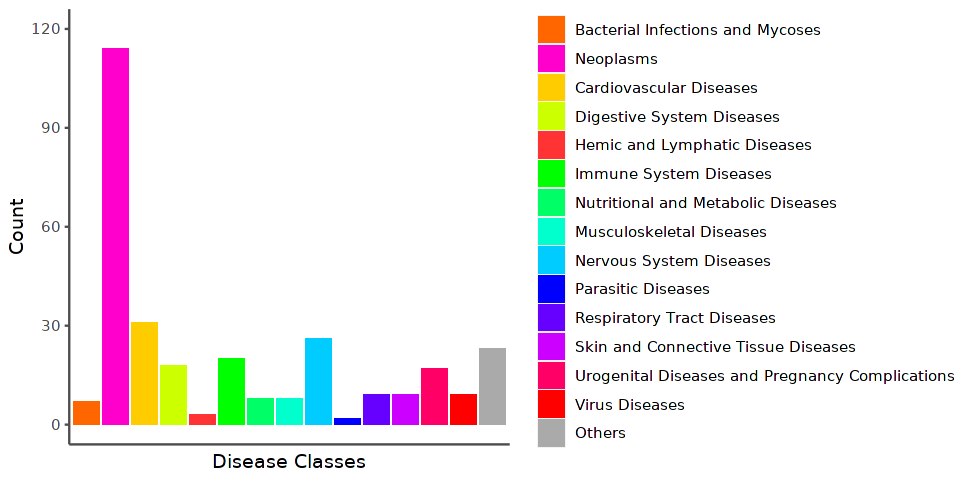

In [13]:
options(repr.plot.width=8, repr.plot.height=4)
f2a

In [23]:
ggsave("./f2a.pdf", f2a, height=100, width=175, units="mm", dpi=600)

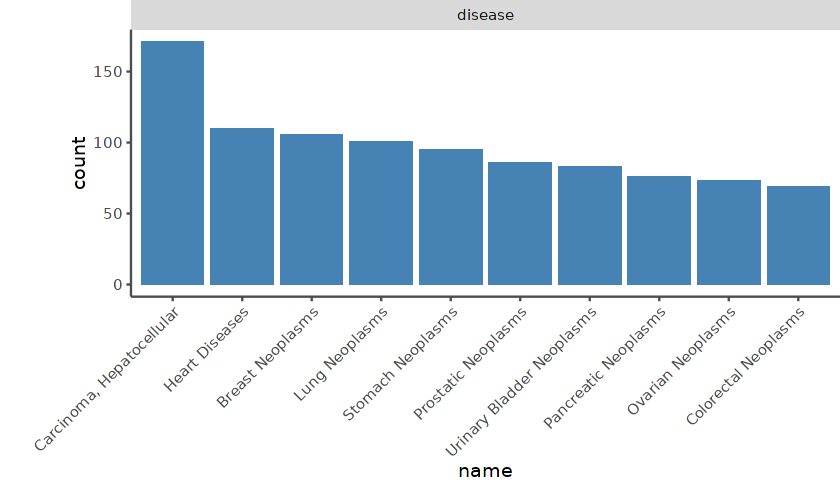

In [33]:
options(repr.plot.width=7, repr.plot.height=4)
f2bc

In [79]:
ggsave("./f2c.pdf", f2bc, height=100, width=100, units="mm", dpi=600)

# Figure 3

## code

In [80]:
node.info <- read_tsv("./results/MRDN_nodes_property.txt")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Nodes = col_character(),
  Category = col_character(),
  Degree = col_double(),
  Positive_Edge = col_double(),
  Negative_Edge = col_double(),
  Cluster_Coefficient = col_double()
)




In [81]:
pnmod <- lm(Negative_Edge ~ Positive_Edge, node.info)
s <- summary(pnmod)
itc <- s$coefficients['(Intercept)', 'Estimate']
bx <- s$coefficients['Positive_Edge', 'Estimate']
lmfunc <- function (x){
    a <- as.numeric(x[4])
    b <- as.numeric(x[5])
    return(bx*a-b+itc)
}
node.info['distance'] <- apply(node.info, 1, lmfunc)

In [82]:
cor.test(node.info$Positive_Edge, node.info$Negative_Edge, method="pearson")


	Pearson's product-moment correlation

data:  node.info$Positive_Edge and node.info$Negative_Edge
t = 8.5259, df = 302, p-value = 7.385e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3450611 0.5268446
sample estimates:
      cor 
0.4404563 


In [89]:
f3b <- ggplot(node.info, aes(Positive_Edge, Negative_Edge)) + 
    geom_point(aes(color=distance)) + 
    scale_color_gradient2(low="steelblue", high="tomato", midpoint=0, limits=c(-20, 20)) + 
    geom_smooth(method="lm") + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"),
         ) + 
    xlim(0,50) + 
    ylim(0,30) + 
    geom_text(data=head(arrange(node.info, distance)), 
              mapping=aes(x=Positive_Edge, y=Negative_Edge, label=Nodes), 
              size=2,
              position="jitter"
             ) + 
    #geom_text(data=head(arrange(node.info, desc(distance))),
    #          mapping=aes(x=Positive_Edge, y=Negative_Edge, label=Nodes), 
    #          size=2,
    #          position="jitter"
    #         ) 
    labs(x="Positive edge", y="Negative edge", color="Distance to\ntrend line")

In [171]:
disf <- read_tsv("./results/MRDN_Distance.txt")
disf <- disf[disf$Distance!=0, ]
pst <- function(x){
    vec <- sort(as.vector(x))
    res <- paste(vec[1], vec[2], sep=".2.")
    return(res)
}
disf['pair'] <- as.vector(apply(disf[,c(1,2)], 1, pst))
disf <- disf[!duplicated(disf$pair), ]


Parsed with column specification:
cols(
  From = col_character(),
  To = col_character(),
  Distance = col_double(),
  Type = col_character()
)



In [172]:
res <- t.test(disf[["Distance"]][disf$Type=="intra"], disf[["Distance"]][disf$Type=="inter"])
res$p.value


	Welch Two Sample t-test

data:  disf[["Distance"]][disf$Type == "intra"] and disf[["Distance"]][disf$Type == "inter"]
t = -11.616, df = 11366, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12486742 -0.08880933
sample estimates:
mean of x mean of y 
 2.474866  2.581704 


In [176]:
disf['Type'] <- factor(disf$Type, ordered=TRUE, levels=c("intra", "inter"))
f3c <- ggplot(disf, aes(x=Type, y=Distance, color=Type, fill=Type)) + 
    geom_violin(scale="area", show.legend=FALSE) + 
    scale_y_continuous(breaks=seq(0,7,1), limits=c(0, 7)) + 
    scale_color_brewer(palette="Set1") +
    scale_fill_brewer(palette="Set1") + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30")
         )

## plot

`geom_smooth()` using formula 'y ~ x'



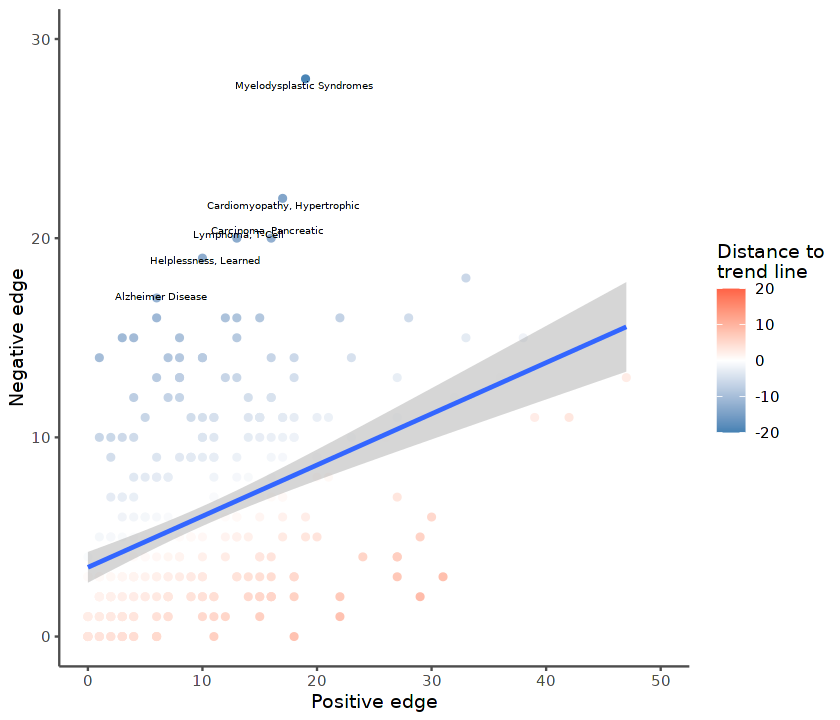

In [90]:
options(repr.plot.width=7, repr.plot.height=6)
f3b

In [92]:
ggsave("./f3b.pdf", height=80, width=170, units="mm", dpi=600)

`geom_smooth()` using formula 'y ~ x'



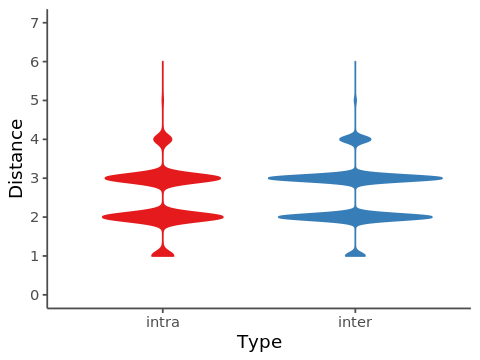

In [175]:
options(repr.plot.width=4, repr.plot.height=3)
f3c

# Fisher Test

In [177]:
disf <- read_tsv("./results/MRDN_diseases.txt")

Parsed with column specification:
cols(
  d1 = col_character(),
  d2 = col_character(),
  similarity = col_double(),
  d1_class = col_character(),
  d2_class = col_character(),
  same_class = col_logical()
)



In [188]:
disf <- disf %>%
    mutate(simabs=abs(similarity))
within_inter <- nrow(disf[(disf$simabs>0.05)&(!disf$same_class),])/2
within_intra <- nrow(disf[(disf$simabs>0.05)&(disf$same_class),])/2
without_inter <- nrow(disf[(disf$simabs<=0.05)&(!disf$same_class),])/2
without_intra <- nrow(disf[(disf$simabs<=0.05)&(disf$same_class),])/2
c(within_inter, within_intra, without_inter, without_intra)

[1]  1829   611 36075  7541

In [189]:
fisher.test(matrix(c(within_intra, within_inter, without_intra, without_inter), nrow=2, byrow=T))$p.value

[1] 1.015729e-20

In [191]:
disfi <- disf %>% filter(simabs > 0.05)
pa <- nrow(disfi[(disfi$similarity>0)&(disfi$same_class),])/2
pe <- nrow(disfi[(disfi$similarity>0)&(!disfi$same_class),])/2
na <- nrow(disfi[(disfi$similarity<0)&(disfi$same_class),])/2
ne <- nrow(disfi[(disfi$similarity<0)&(!disfi$same_class),])/2
c(pa, na, pe, ne)

[1]  432  179 1089  740

In [192]:
fisher.test(matrix(c(pa, pe, na, ne), nrow=2, byrow=TRUE))$p.value

[1] 6.590614e-07

# coherent

## code

In [211]:
coh_shuffle <- read.table("./results/coherent/MRDN_Coherent_Shuffle.txt", sep="\t", header=TRUE)
coh_shuffle['method'] <- "shuffle"
coh_rewiring <- read.table("./results/coherent/MRDN_Coherent_Rewiring.txt", sep="\t", header=TRUE)
coh_rewiring['method'] <- "rewiring"
coh <- rbind(coh_shuffle, coh_rewiring)

In [212]:
aggregate(coh[, c(1:3)], by=list(factor(coh$method)), FUN=mean)

Group.1,all,coherent,ratio
<fct>,<dbl>,<dbl>,<dbl>
rewiring,688.5768,349.4877,1.033769
shuffle,1537.5595,1378.3460,8.720209


In [213]:
t.test(x=coh_shuffle$ratio, mu=16.02)


	One Sample t-test

data:  coh_shuffle$ratio
t = -889.08, df = 9999, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 16.02
95 percent confidence interval:
 8.704115 8.736303
sample estimates:
mean of x 
 8.720209 


In [214]:
cohp <- ggplot(coh, aes(x=ratio)) + 
    geom_smooth(stat="density", size=0.5) + 
    scale_x_continuous(limits=c(6,18), breaks=seq(6,18,2)) + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"),
         ) + 
    facet_wrap(. ~ method, scales="free") + 
    annotate("segment", x=16, xend=16, y=0.2, yend=0.05, arrow=arrow(length=unit(3,"mm")), size=0.6, color="firebrick3")


## plot

Warning message:
“Removed 10000 rows containing non-finite values (stat_density).”


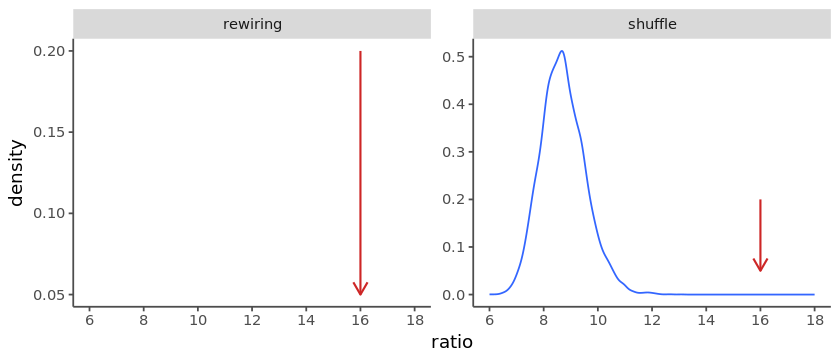

In [215]:
options(repr.plot.width=7, repr.plot.height=3)
cohp

# Figure 4

## code

In [93]:
mirmat <- read.table("./results/HMDD_similarity_matrix.txt", sep="\t", header=TRUE, row.names=1, check.names = FALSE, quote = "")

In [105]:
dname <- 'Aortic Aneurysm, Abdominal'
omat <- mirmat[order(mirmat[, dname]), c('Aortic Aneurysm, Abdominal', dname)]
vmat <- rbind(head(omat, 10), tail(omat, 11)[-11, ])
colnames(vmat) <- c("aaa", "disease")
vmat['xlab'] <- factor(rownames(vmat), ordered=TRUE, levels=rownames(vmat))
vmat['group'] <- factor(cut(vmat$disease, c(-1, 0, 1), labels=c("opposite", "similar")), 
                        ordered=TRUE, levels=c("similar", "opposite"))
simp <- ggplot(vmat, aes(x = xlab, y = disease, fill = group)) + 
  geom_col() + 
  scale_fill_manual(values=c("steelblue2", "firebrick1")) + 
  labs(x="Disease", y="Simiarity", title=dname) + 
  ylim(-0.2, 0.3) + 
  theme(panel.background = element_blank(), 
        panel.grid = element_blank(), 
        legend.position = "none", 
        axis.ticks.y = element_blank(), 
        axis.line.x = element_line(),
        plot.title = element_text(size=10)) + 
  coord_flip()

## plot

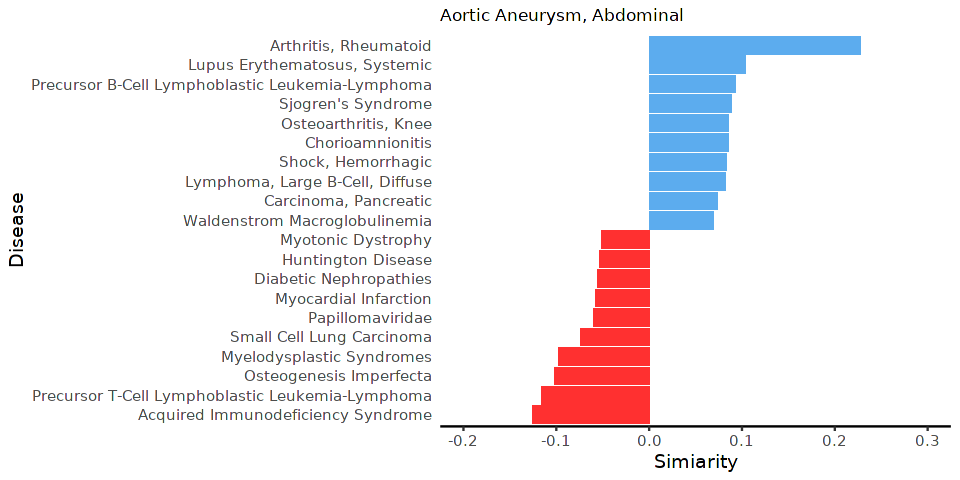

In [106]:
options(repr.plot.width=8, repr.plot.height=4)
simp

In [110]:
ggsave("./f4b.pdf", height=80, width=140, units="mm", dpi=600)

# Table S1

## code

In [105]:
exp_data <- read_tsv("./results/HMDD_tissue.txt")
dcategory <- read_tsv("./results/MRDN_nodes_category.txt")
dcategory <- dcategory %>%
    rename(disease=Nodes)
exp_data <- exp_data %>%
    group_by(`pri-miRNA`, disease) %>%
    summarize(regulation=sum(regulation)) %>%
    filter(regulation != 0) %>%
    left_join(dcategory)
mir <- exp_data %>%
    group_by(`pri-miRNA`) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10)
ts1 <- exp_data %>%
    group_by(`pri-miRNA`, Category) %>%
    summarize(count=n()) %>%
    filter((Category == "Neoplasms") | (Category == "Cardiovascular Diseases")) %>%
    spread(key=Category, value=count) %>%
    right_join(mir)

Parsed with column specification:
cols(
  `pri-miRNA` = col_character(),
  disease = col_character(),
  regulation = col_double()
)

Parsed with column specification:
cols(
  Nodes = col_character(),
  Category = col_character()
)

Joining, by = "disease"
Joining, by = "pri-miRNA"


## table

In [106]:
ts2

pri-miRNA,Cardiovascular Diseases,Neoplasms,count
<chr>,<int>,<int>,<int>
hsa-mir-21,10,50,86
hsa-mir-155,6,33,66
hsa-mir-146a,2,18,43
hsa-mir-145,2,31,41
hsa-mir-125b,1,19,39
hsa-mir-143,1,21,38
hsa-mir-17,1,28,36
hsa-mir-16,1,22,35
hsa-mir-31,2,30,35


# Response 

## Reviewer 1

In [39]:
# Similarity distribution
sim_matrix <- read_tsv("./results/HMDD_similarity_matrix.txt", 
                       col_type=cols(.default="d", disease="c"))

In [57]:
sim_matrix_long <- sim_matrix %>%
    gather(d2, similarity, -disease) %>%
    filter(!disease==d2) %>%
    filter(!similarity==0) %>%
    mutate(disease_pair=sapply(1:n(), function(x){
        paste(sort(c(disease[x], d2[x])), collapse = ";")
    }), .before=1) %>%
    select(-disease, -d2) %>%
    distinct() %>%
    separate(disease_pair, into=c("disease1", "disease2"), sep=";")

In [245]:
dist_sim <- sim_matrix_long %>%
    plotDensity("similarity") + 
    labs(title="")
#ggsave("./response/1_Distribution_of_disease_similarity.png", height=4, width=5, units="in", dpi=600)

In [59]:
# Top and bottom similarity scores
top_sim <- sim_matrix_long %>%
    mutate(direction=ifelse(similarity>0, "similar", "opposite")) %>%
    arrange(desc(abs(similarity))) %>%
    group_by(direction) %>%
    slice(1:10) %>%
    arrange(desc(similarity))
write_xlsx(top_sim, "./response/1_Top_similarity.xlsx")

In [63]:
aaa <- "Aortic Aneurysm, Abdominal"
sim_matrix_long %>%
    filter(disease1==aaa|disease2==aaa) %>%
    filter(abs(similarity)>0.05) %>%
    arrange(desc(similarity))

disease1,disease2,similarity
<chr>,<chr>,<dbl>
"Aortic Aneurysm, Abdominal","Arthritis, Rheumatoid",0.22723675
"Aortic Aneurysm, Abdominal","Lupus Erythematosus, Systemic",0.10325398
"Aortic Aneurysm, Abdominal",Precursor B-Cell Lymphoblastic Leukemia-Lymphoma,0.09308278
"Aortic Aneurysm, Abdominal",Sjogren's Syndrome,0.08837866
"Aortic Aneurysm, Abdominal",Chorioamnionitis,0.08570278
"Aortic Aneurysm, Abdominal","Osteoarthritis, Knee",0.08570278
"Aortic Aneurysm, Abdominal","Shock, Hemorrhagic",0.08318286
"Aortic Aneurysm, Abdominal","Lymphoma, Large B-Cell, Diffuse",0.08258930
"Aortic Aneurysm, Abdominal","Carcinoma, Pancreatic",0.07338528


1. miRNA-Disease Score Distribution

In [4]:
weight_matrix <- read_tsv("./results/HMDD_weight_matrix.txt", 
                          col_type=cols(.default="d", disease="c"))

In [35]:
weight_matrix_long <- weight_matrix %>%
    gather(miRNA, weight, -disease) %>%
    filter(weight!=0) 

In [268]:
dist_weight <- weight_matrix_long %>%
    plotDensity("weight") + 
    scale_x_continuous(breaks=seq(-25, 50, by=10)) + 
    labs(title="", x="Weights")
#ggsave("./response/1_Distribution_of_miRNA_Weights.png", height=4, width=5, units="in", dpi=600)

In [32]:
# Top and bottom miRNA disease scores
top_weight <- weight_matrix_long %>%
    mutate(direction=ifelse(weight>0, "upregulated", "downregulated")) %>%
    arrange(desc(abs(weight))) %>%
    group_by(direction) %>%
    slice(1:10) %>%
    arrange(desc(weight))
write_xlsx(top_weight, "./response/1_Top_weights.xlsx")

In [65]:
weight_matrix_long %>%
    mutate(direction=ifelse(weight>0, "upregulated", "downregulated")) %>%
    filter(disease=="Aortic Aneurysm, Abdominal") %>%
    write_xlsx("./response/1_AAA_miRNA_weights.xlsx")

In [274]:
# All miRNA disease scores
all_weight <- weight_matrix_long %>%
    mutate(direction=ifelse(weight>0, "upregulated", "downregulated")) %>%
    arrange(desc(abs(weight))) %>%
    group_by(direction) %>%
    arrange(desc(weight))
write_xlsx(all_weight, "./response/1_All_weights.xlsx")

3. Plot all distributions

In [137]:
nodes <- read_tsv("./results/MRDN_nodes_property.txt")

edges <- read_tsv("./results/MRDN_edges.txt")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Nodes = col_character(),
  Category = col_character(),
  Degree = col_double(),
  Positive_Edge = col_double(),
  Negative_Edge = col_double(),
  Cluster_Coefficient = col_double()
)




In [269]:
fields <- c("Degree", "Positive_Edge", "Negative_Edge", "Cluster_Coefficient")
pl <- lapply(fields, function(x){
    nodes %>%
    plotDensity(x) + 
    labs(title="", x=str_replace(x, "_", " "))
})

In [270]:
pl$dist_weight <- dist_weight
pl$dist_sim <- dist_sim

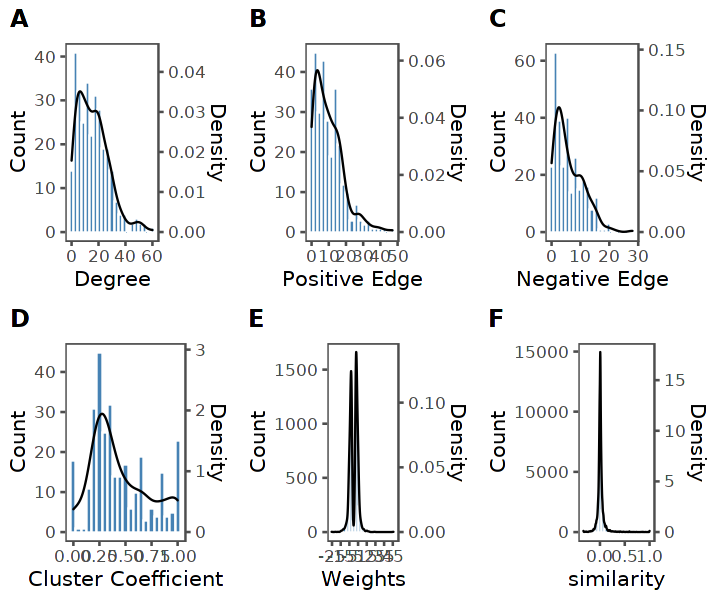

In [277]:
ggpubr::ggarrange(plotlist = pl, ncol=3, nrow=2, labels=c("A", "B", "C", "D", "E", "F"))
ggsave("./response/suppfig_2.png", height=5, width=9, units="in", dpi=600)

## Reviewer 2

1. Narrow down process

In [137]:
nodes <- read_tsv("./results/MRDN_nodes_property.txt")

edges <- read_tsv("./results/MRDN_edges.txt")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Nodes = col_character(),
  Category = col_character(),
  Degree = col_double(),
  Positive_Edge = col_double(),
  Negative_Edge = col_double(),
  Cluster_Coefficient = col_double()
)




In [195]:
neighbors <- lapply(nodes$Nodes, function(x){
    neighbor_edges <- edges %>%
        filter(Disease1==x|Disease2==x)
    tibble(Node=x, Neighbor=setdiff(unique(c(neighbor_edges$Disease1, neighbor_edges$Disease2)), x)) %>%
        left_join(rename(nodes[, 1:2], Node=Nodes), by="Node") %>%
        left_join(rename(nodes[, 1:2], Neighbor=Nodes, Neighbor_Cate=Category), by="Neighbor")
}) %>% bind_rows()

In [196]:
get_most_cate <- function(x){
    tmp <- tibble(x=x) %>%
        group_by(x) %>%
        summarise(n=n(), .groups="drop") %>%
        filter(n==max(n))
    tmp
}

In [197]:
getEntropy <- function(x){
    p <- rle(sort(x))$length/length(x)
    ent <- -sum(p*log2(p))
    return(ent)
}

In [198]:
neighbor_info <- neighbors %>%
    group_by(Node) %>%
    summarise(same_cate_neighbor=sum(Category==Neighbor_Cate), 
              entropy=getEntropy(Neighbor_Cate), 
              top_cate_neighbor=get_most_cate(Neighbor_Cate)$x, 
              top_cate_number=get_most_cate(Neighbor_Cate)$n, 
              .groups="drop") %>%
    arrange(desc(same_cate_neighbor)) %>%
    left_join(nodes %>% rename(Node=Nodes), by="Node")

In [206]:
neighbor_info %>%
    select(Node, Category, Degree, same_cate_neighbor, top_cate_neighbor, top_cate_number) %>%
    rename(Neighbors_from_same_category = same_cate_neighbor, 
           Top_category_of_neighbors = top_cate_neighbor, 
           Neighbors_from_top_category = top_cate_number) %>%
    write_xlsx("./response/2_5_Neighbor_Categories.xlsx")

In [217]:
neighbor_info %>%
    filter(top_cate_neighbor != Category) %>%
    #filter(top_cate_neighbor=="Neoplasms") %>%
    filter(Category=="Cardiovascular Diseases") %>%
    arrange(desc(top_cate_number)) %>%
    select(Node, Category, Degree, same_cate_neighbor, top_cate_neighbor, top_cate_number) %>%
    rename(Neighbors_from_same_category = same_cate_neighbor, 
           Top_category_of_neighbors = top_cate_neighbor, 
           Neighbors_from_top_category = top_cate_number) %>%
    write_xlsx("./response/2_5_Neighbor_Categories_cardiac.xlsx")

In [239]:
neighbor_info %>%
    filter(top_cate_neighbor != Category) %>%
    filter(top_cate_neighbor!="Neoplasms") %>%
    arrange(desc(top_cate_number))

Node,same_cate_neighbor,entropy,top_cate_neighbor,top_cate_number,Category,Degree,Positive_Edge,Negative_Edge,Cluster_Coefficient
<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Pituitary Neoplasms,6,2.595476,Cardiovascular Diseases,10,Neoplasms,26,16,10,0.3292308
"Lupus Erythematosus, Systemic",8,3.128706,Nervous System Diseases,9,Immune System Diseases,51,33,18,0.2839216
Rhabdomyosarcoma,3,2.510900,Cardiovascular Diseases,8,Neoplasms,21,7,14,0.5428571
Musculoskeletal Abnormalities,0,2.490602,Cardiovascular Diseases,8,Musculoskeletal Diseases,24,16,8,0.4528986
"Aortic Aneurysm, Abdominal",1,3.051596,Immune System Diseases,7,Cardiovascular Diseases,28,18,10,0.3571429
"Thrombocythemia, Essential",1,2.437066,Cardiovascular Diseases,7,Hemic and Lymphatic Diseases,19,13,6,0.6023392
"Thyroid Carcinoma, Anaplastic",5,3.290704,Cardiovascular Diseases,6,Neoplasms,37,23,14,0.3603604
"Thyroid Carcinoma, Anaplastic",5,3.290704,Nervous System Diseases,6,Neoplasms,37,23,14,0.3603604
Crohn Disease,0,2.772185,Immune System Diseases,6,Digestive System Diseases,22,15,7,0.5064935


2. Permutation test

In [284]:
library("igraph")

getImmNeibor <- function(g){
    aaa_index <- which(V(g)$name=="Aortic Aneurysm, Abdominal")
    ends(g, E(g)[from(aaa_index)]) %>%
        apply(1, paste0, collapse="") %>%
        str_replace("Aortic Aneurysm, Abdominal", "") %>%
        tibble() %>% setNames(c("Nodes")) %>%
        left_join(nodes[, 1:2], by="Nodes") %>%
        filter(Category=="Immune System Diseases") %>%
        nrow()
}


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [289]:
g <- graph_from_data_frame(edges, directed=F)

In [416]:
getImmNeibor(g)

[1] 7

In [417]:
perm_imm <- sapply(1:10000, function(x){
    g1 <- rewire(g, keeping_degseq(niter=vcount(g)*10))
    return(getImmNeibor(g1))
})

In [445]:
t.test(perm_imm[1:10000], mu=7)


	One Sample t-test

data:  perm_imm[1:10000]
t = -262.53, df = 9999, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 7
95 percent confidence interval:
 3.114907 3.172493
sample estimates:
mean of x 
   3.1437 


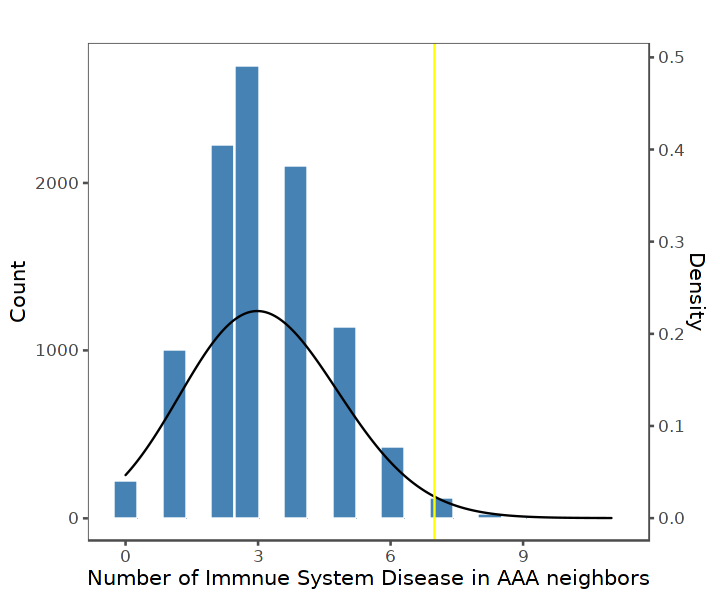

In [430]:
tibble(perm=perm_imm) %>%
    plotDensity("perm", bw=1) +
    geom_vline(xintercept=7, color="yellow") + 
    labs(title="", x="Number of Immnue System Disease in AAA neighbors")
ggsave("./response/perm.pdf", height=4, width=5, units="in", dpi=600)


3. Summary AAA miRNAs

In [225]:
aaa_mirna <- weight_matrix_long %>%
    filter(disease=="Aortic Aneurysm, Abdominal") %>%
    select(miRNA) %>% deframe()

In [230]:
aaa_mirna

[1] "hsa-mir-124a" "hsa-mir-126"  "hsa-mir-146a" "hsa-mir-155"  "hsa-mir-223" 
[6] "hsa-mir-29b"

In [282]:
weight_matrix_long %>%
    filter(miRNA %in% aaa_mirna) %>%
    select(disease) %>%
    distinct() %>%
    left_join(nodes %>% rename(disease=Nodes), by="disease") %>%
    group_by(Category) %>%
    summarise(n=n()) %>%
    arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)



Category,n
<chr>,<int>
Neoplasms,48
Immune System Diseases,12
Nervous System Diseases,11
Cardiovascular Diseases,9
Others,6
Skin and Connective Tissue Diseases,6
Digestive System Diseases,4
Urogenital Diseases and Pregnancy Complications,4
Bacterial Infections and Mycoses,3
